---

# HandsOn_14-2
   
<br>

* created by thk. 20.11.03.

---

## 라이브러리 불러오기

In [3]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow.keras import layers, models
assert tf.__version__ >= "2.0"

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

import pandas as pd
import seaborn as sns

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_loss(history):
    plt.plot(pd.DataFrame(history.history))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.legend(('loss', 'v_loss'))
    plt.show()

## VGG16 구조 살펴보기

In [4]:
model = tf.keras.applications.VGG16(weights="imagenet")

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

---

## CNN output size 계산법

<br>

* **Parameters**

    * input_size - N
    * filter (convolution) kernel_size - k
    * pooling kernel_size - PL
    * strides size - S
    * padding size = PD
    * output_size - O

<br>

* **Convolutional layer의 출력 크기**

<br>

O = ((N - k + 2PD) / S) + 1

<br>

* **Pooling layer의 출력 크기**

O = N/PL

<br>

## VGG 구현하기

In [ ]:
# # load
# (img, y_train), (img_test, y_test) = tf.keras.datasets.mnist.load_data()
# print('* Load')
# print('Train set: ', img.shape, img[0][10])
# print('Test set: ', img_test.shape, img_test[0][10])

In [ ]:
# def preProcessing(img, img_test):

#     # reshape
#     # 차원 3 추가
#     print('* Reshape')
#     x_train = np.reshape(img, (img.shape[0], img.shape[1], img.shape[2], 1))
#     x_test = np.reshape(img_test, (img_test.shape[0], img_test.shape[1], img_test.shape[2], 1))
#     print(x_train.shape)
#     print(x_test.shape)
    
#     # Normalize
#     print('* Normailze')
#     x_train = x_train / 255
#     x_test = x_test / 255
#     print(x_train.shape)
#     print(x_test.shape)
    
#     return x_train, x_test

In [ ]:
# img.shape[0]
# img.shape[1]*img.shape[2]*1

In [10]:
model_vgg = tf.keras.models.Sequential([
    # vgg16, kernel_size=(3*3), activation="relu", padding="same"
    # Pooling_Output_Size = Input_Size/Pooling_Kernel_Size -> 112 = 224/2 -> kernel size = 2
    # pooling layer default strides = 2 => pool_size=(2,2), strides=(2,2)
    
    # layer 1 - conv layer 1
    layers.Conv2D(input_shape=(224,224,3), filters=64, kernel_size=3, 
                  activation="relu", padding="same"),
    # layer 2 - conv layer 2
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding ="same"),
    
    # layer 3 - pooling layer
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    # layer 4 - conv layer 3
    layers.Conv2D(filters=128, kernel_size=3, activation = "relu", padding="same"),
    
    # layer 5 - conv layer 4
    layers.Conv2D(filters=128, kernel_size=3, activation = "relu", padding="same"),
    
    # layer 6 - pooling layer
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    # layer 7 - conv layer 5
    layers.Conv2D(filters=256, kernel_size=3, activation = "relu", padding="same"),

    # layer 8 - conv layer 6
    layers.Conv2D(filters=256, kernel_size=3, activation = "relu", padding="same"),

    # layer 9 - conv layer 7
    layers.Conv2D(filters=256, kernel_size=3, activation = "relu", padding="same"),

    # layer 10 - pooling layer 8
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),    
    
    # layer 11 - conv layer 9
    layers.Conv2D(filters=512, kernel_size=3, activation = "relu", padding="same"),

    # layer 12 - conv layer 10
    layers.Conv2D(filters=512, kernel_size=3, activation = "relu", padding="same"),

    # layer 13 - conv layer 11
    layers.Conv2D(filters=512, kernel_size=3, activation = "relu", padding="same"),

    # layer 14 - pooling layer
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),    

    # layer 15 - conv layer 12
    layers.Conv2D(filters=512, kernel_size=3, activation = "relu", padding="same"),

    # layer 16 - conv layer 13
    layers.Conv2D(filters=512, kernel_size=3, activation = "relu", padding="same"),

    # layer 17 - conv layer 14
    layers.Conv2D(filters=512, kernel_size=3, activation = "relu", padding="same"),

    # layer 18 - pooling layer
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)), 

    # layer 19 - Flatten
    layers.Flatten(),
    
    # layer 20 - dense layer
    layers.Dense(4096, activation = "relu"),
    
    # layer 21 - dense layer
    layers.Dense(4096, activation = "relu"),

    # layer 22 - output layer
    layers.Dense(10, activation = "softmax")
])

In [11]:
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 256)      

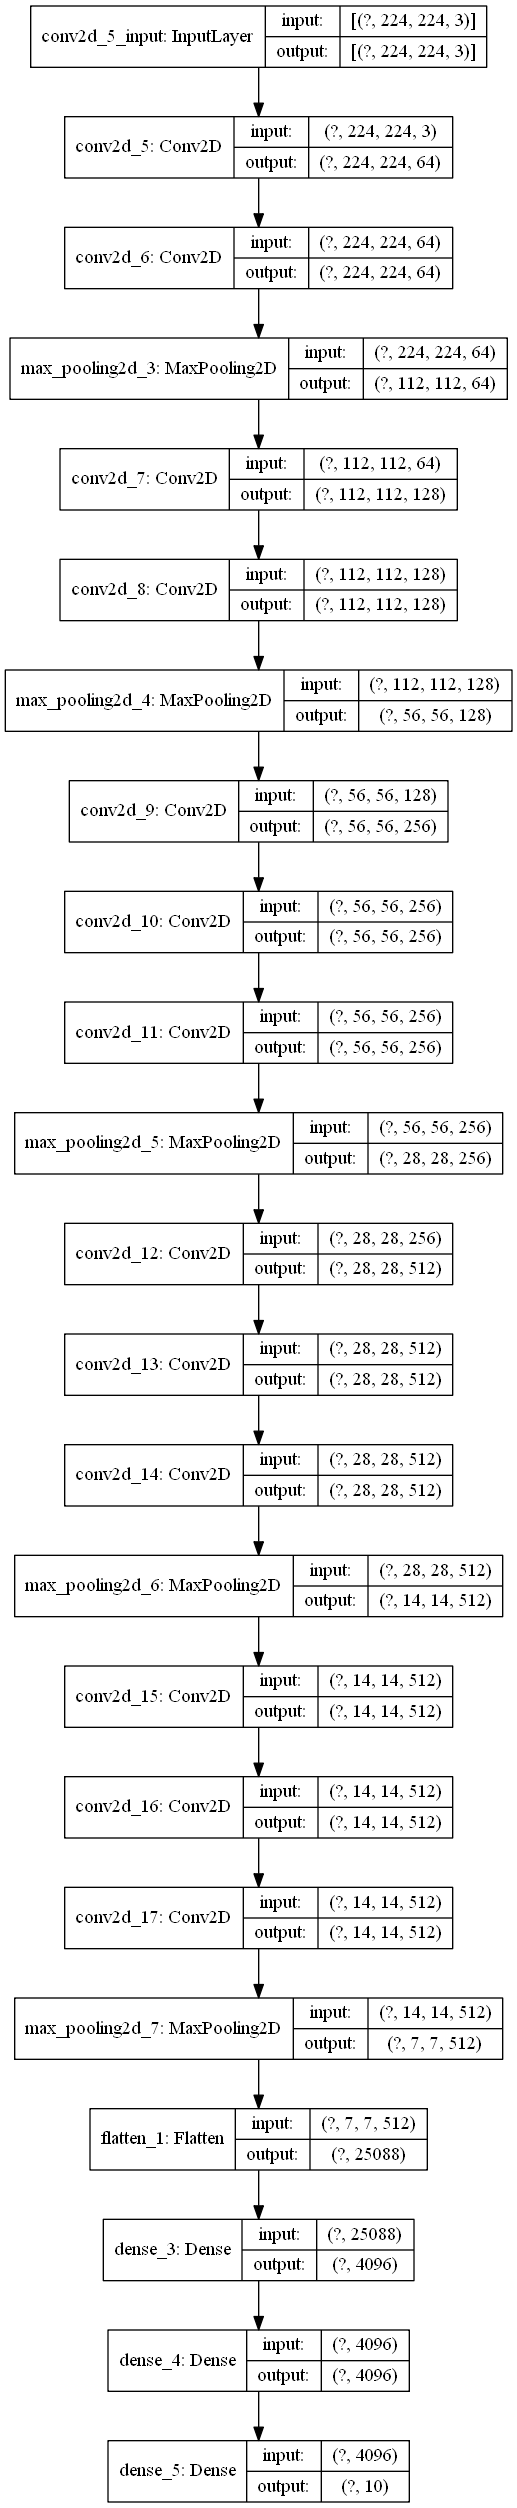

In [12]:
tf.keras.utils.plot_model(model_vgg, show_shapes=True)

In [ ]:
# # 모델 컴파일
# model_vgg.compile(loss="sparse_categorical_crossentropy", # label이 정수
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=["accuracy"])

# # 콜백 선언
# model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('model_vgg16.h5', 
#                                                          save_best_only=True)

# # 모델 훈련
# # model.fit(x_train, y_train, 
# #           validation_split=0.2,
# #           epochs=10,
# #           callbacks=[model_checkpoint_cb])

In [ ]:
# # load model
# model_vgg16 = tf.keras.models.load_model('model_vgg16.h5')

# # evaluate model
# vgg_test = model_vgg16.evaluate(x_test, y_test)

In [ ]:
# # 훈련 후 모델 예측
# y_pred = model_vgg16_cnn.predict(x_test)
# y_pred_class = np.argmax(y_pred, axis=1)
# y_pred_class = y_pred_class.tolist()

In [ ]:
# p = sns.heatmap(confusion_matrix(y_test,y_pred_class),annot=True,fmt='2.0f')
# p.set_ylabel('Actual label');
# p.set_xlabel('Predicted label');

In [ ]:
# print(classification_report(y_test, y_pred_class))